# GraphCast

This colab lets you run several versions of GraphCast.

The model weights, normalization statistics, and example inputs are available on [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/dm_graphcast).

A Colab runtime with TPU/GPU acceleration will substantially speed up generating predictions and computing the loss/gradients. If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".

> <p><small><small>Copyright 2023 DeepMind Technologies Limited.</small></p>
> <p><small><small>Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0">http://www.apache.org/licenses/LICENSE-2.0</a>.</small></small></p>
> <p><small><small>Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.</small></small></p>

# Installation and Initialization


In [1]:
# @title Pip install graphcast and dependencies

%pip install --upgrade https://github.com/deepmind/graphcast/archive/master.zip

DEPRECATION: Loading egg at /home/aryan/DS340W-Project/venv/lib/python3.12/site-packages/graphcast-0.1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached https://github.com/deepmind/graphcast/archive/master.zip
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
# @title Workaround for cartopy crashes

# Workaround for cartopy crashes due to the shapely installed by default in
# google colab kernel (https://github.com/anitagraser/movingpandas/issues/81):
!pip uninstall -y shapely
!pip install shapely --no-binary shapely]

Found existing installation: shapely 2.0.6
Uninstalling shapely-2.0.6:
  Successfully uninstalled shapely-2.0.6
DEPRECATION: Loading egg at /home/aryan/DS340W-Project/venv/lib/python3.12/site-packages/graphcast-0.1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached shapely-2.0.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
Using cached shapely-2.0.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)


In [3]:
# @title Imports

import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

import cartopy.crs as ccrs
#from google.cloud import storage
from graphcast import autoregressive
from graphcast import casting
from graphcast import checkpoint
from graphcast import data_utils
from graphcast import graphcast
from graphcast import normalization
from graphcast import rollout
from graphcast import xarray_jax
from graphcast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray


def parse_file_parts(file_name):
  return dict(part.split("-", 1) for part in file_name.split("_"))


In [4]:
# @title Authenticate with Google Cloud Storage

from google.cloud import storage
gcs_client = storage.Client.create_anonymous_client()
gcs_bucket = gcs_client.get_bucket("dm_graphcast")

In [5]:
# @title Plotting functions

def select(
    data: xarray.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xarray.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data

def scale(
    data: xarray.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xarray.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
    if "time" in first_data.dims:
      td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
      figure.suptitle(f"{fig_title}, {td}", fontsize=16)
    else:
      figure.suptitle(fig_title, fontsize=16)
    for im, (plot_data, norm, cmap) in zip(images, data.values()):
      im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())

# Load the Data and initialize the model

## Load the model params

Choose one of the two ways of getting model params:
- **random**: You'll get random predictions, but you can change the model architecture, which may run faster or fit on your device.
- **checkpoint**: You'll get sensible predictions, but are limited to the model architecture that it was trained with, which may not fit on your device. In particular generating gradients uses a lot of memory, so you'll need at least 25GB of ram (TPUv4 or A100).

Checkpoints vary across a few axes:
- The mesh size specifies the internal graph representation of the earth. Smaller meshes will run faster but will have worse outputs. The mesh size does not affect the number of parameters of the model.
- The resolution and number of pressure levels must match the data. Lower resolution and fewer levels will run a bit faster. Data resolution only affects the encoder/decoder.
- All our models predict precipitation. However, ERA5 includes precipitation, while HRES does not. Our models marked as "ERA5" take precipitation as input and expect ERA5 data as input, while model marked "ERA5-HRES" do not take precipitation as input and are specifically trained to take HRES-fc0 as input (see the data section below).

We provide three pre-trained models.
1. `GraphCast`, the high-resolution model used in the GraphCast paper (0.25 degree resolution, 37 pressure levels), trained on ERA5 data from 1979 to 2017,

2. `GraphCast_small`, a smaller, low-resolution version of GraphCast (1 degree resolution, 13 pressure levels, and a smaller mesh), trained on ERA5 data from 1979 to 2015, useful to run a model with lower memory and compute constraints,

3. `GraphCast_operational`, a high-resolution model (0.25 degree resolution, 13 pressure levels) pre-trained on ERA5 data from 1979 to 2017 and fine-tuned on HRES data from 2016 to 2021. This model can be initialized from HRES data (does not require precipitation inputs).


In [6]:
# @title Choose the model

params_file_options = [
    name for blob in gcs_bucket.list_blobs(prefix="params/")
    if (name := blob.name.removeprefix("params/"))]  # Drop empty string.

random_mesh_size = widgets.IntSlider(
    value=4, min=4, max=6, description="Mesh size:")
random_gnn_msg_steps = widgets.IntSlider(
    value=4, min=1, max=32, description="GNN message steps:")
random_latent_size = widgets.Dropdown(
    options=[int(2**i) for i in range(4, 10)], value=32,description="Latent size:")
random_levels = widgets.Dropdown(
    options=[13, 37], value=13, description="Pressure levels:")


params_file = widgets.Dropdown(
    options=params_file_options,
    description="Params file:",
    layout={"width": "max-content"})

source_tab = widgets.Tab([
    widgets.VBox([
        random_mesh_size,
        random_gnn_msg_steps,
        random_latent_size,
        random_levels,
    ]),
    params_file,
])
source_tab.set_title(0, "Random")
source_tab.set_title(1, "Checkpoint")
widgets.VBox([
    source_tab,
    widgets.Label(value="Run the next cell to load the model. Rerunning this cell clears your selection.")
])


In [7]:
# @title Load the model

source = source_tab.get_title(source_tab.selected_index)

if source == "Random":
  params = None  # Filled in below
  state = {}
  model_config = graphcast.ModelConfig(
      resolution=0,
      mesh_size=random_mesh_size.value,
      latent_size=random_latent_size.value,
      gnn_msg_steps=random_gnn_msg_steps.value,
      hidden_layers=1,
      radius_query_fraction_edge_length=0.6)
  task_config = graphcast.TaskConfig(
      input_variables=graphcast.TASK.input_variables,
      target_variables=graphcast.TASK.target_variables,
      forcing_variables=graphcast.TASK.forcing_variables,
      pressure_levels=graphcast.PRESSURE_LEVELS[random_levels.value],
      input_duration=graphcast.TASK.input_duration,
  )
else:
  assert source == "Checkpoint"
  with gcs_bucket.blob(f"params/{params_file.value}").open("rb") as f:
    ckpt = checkpoint.load(f, graphcast.CheckPoint)
  params = ckpt.params
  state = {}

  model_config = ckpt.model_config
  task_config = ckpt.task_config
  print("Model description:\n", ckpt.description, "\n")
  print("Model license:\n", ckpt.license, "\n")

model_config

ModelConfig(resolution=0, mesh_size=4, latent_size=32, gnn_msg_steps=4, hidden_layers=1, radius_query_fraction_edge_length=0.6, mesh2grid_edge_normalization_factor=None)

## Load the example data

Several example datasets are available, varying across a few axes:
- **Source**: fake, era5, hres
- **Resolution**: 0.25deg, 1deg, 6deg
- **Levels**: 13, 37
- **Steps**: How many timesteps are included

Not all combinations are available.
- Higher resolution is only available for fewer steps due to the memory requirements of loading them.
- HRES is only available in 0.25 deg, with 13 pressure levels.

The data resolution must match the model that is loaded.

Some transformations were done from the base datasets:
- We accumulated precipitation over 6 hours instead of the default 1 hour.
- For HRES data, each time step corresponds to the HRES forecast at leadtime 0, essentially providing an "initialisation" from HRES. See HRES-fc0 in the GraphCast paper for further description. Note that a 6h accumulation of precipitation is not available from HRES, so our model taking HRES inputs does not depend on precipitation. However, because our models predict precipitation, we include the ERA5 precipitation in the example data so it can serve as an illustrative example of ground truth.
- We include ERA5 `toa_incident_solar_radiation` in the data. Our model uses the radiation at -6h, 0h and +6h as a forcing term for each 1-step prediction. If the radiation is missing from the data (e.g. in an operational setting), it will be computed using a custom implementation that produces values similar to those in ERA5.

In [8]:
# @title Get and filter the list of available example datasets

dataset_file_options = [
    name for blob in gcs_bucket.list_blobs(prefix="dataset/")
    if (name := blob.name.removeprefix("dataset/"))]  # Drop empty string.

def data_valid_for_model(
    file_name: str, model_config: graphcast.ModelConfig, task_config: graphcast.TaskConfig):
  file_parts = parse_file_parts(file_name.removesuffix(".nc"))
  return (
      model_config.resolution in (0, float(file_parts["res"])) and
      len(task_config.pressure_levels) == int(file_parts["levels"]) and
      (
          ("total_precipitation_6hr" in task_config.input_variables and
           file_parts["source"] in ("era5", "fake")) or
          ("total_precipitation_6hr" not in task_config.input_variables and
           file_parts["source"] in ("hres", "fake"))
      )
  )


dataset_file = widgets.Dropdown(
    options=[
        (", ".join([f"{k}: {v}" for k, v in parse_file_parts(option.removesuffix(".nc")).items()]), option)
        for option in dataset_file_options
        if data_valid_for_model(option, model_config, task_config)
    ],
    description="Dataset file:",
    layout={"width": "max-content"})
widgets.VBox([
    dataset_file,
    widgets.Label(value="Run the next cell to load the dataset. Rerunning this cell clears your selection and refilters the datasets that match your model.")
])

In [9]:
# @title Load weather data

if not data_valid_for_model(dataset_file.value, model_config, task_config):
  raise ValueError(
      "Invalid dataset file, rerun the cell above and choose a valid dataset file.")

with gcs_bucket.blob(f"dataset/{dataset_file.value}").open("rb") as f:
  example_batch = xarray.load_dataset(f).compute()

assert example_batch.dims["time"] >= 3  # 2 for input, >=1 for targets

print(", ".join([f"{k}: {v}" for k, v in parse_file_parts(dataset_file.value.removesuffix(".nc")).items()]))

example_batch

source: era5, date: 2022-01-01, res: 0.25, levels: 13, steps: 01


/tmp/ipykernel_13342/4169645414.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  assert example_batch.dims["time"] >= 3  # 2 for input, >=1 for targets


<xarray.Dataset> Size: 1GB
Dimensions:                       (lon: 1440, lat: 721, level: 13, time: 3,
                                   batch: 1)
Coordinates:
  * lon                           (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * lat                           (lat) float32 3kB -90.0 -89.75 ... 89.75 90.0
  * level                         (level) int32 52B 50 100 150 ... 850 925 1000
  * time                          (time) timedelta64[ns] 24B 00:00:00 ... 12:...
    datetime                      (batch, time) datetime64[ns] 24B 2022-01-01...
Dimensions without coordinates: batch
Data variables: (12/14)
    geopotential_at_surface       (lat, lon) float32 4MB 2.735e+04 ... -0.07617
    land_sea_mask                 (lat, lon) float32 4MB 1.0 1.0 1.0 ... 0.0 0.0
    2m_temperature                (batch, time, lat, lon) float32 12MB 250.7 ...
    mean_sea_level_pressure       (batch, time, lat, lon) float32 12MB 9.931e...
    10m_v_component_of_wind       (batch, time, lat, lon) float32 12MB -0.439...
    10m_u_component_of_wind       (batch, time, lat, lon) float32 12MB 1.309 ...
    ...                            ...
    temperature                   (batch, time, level, lat, lon) float32 162MB ...
    geopotential                  (batch, time, level, lat, lon) float32 162MB ...
    u_component_of_wind           (batch, time, level, lat, lon) float32 162MB ...
    v_component_of_wind           (batch, time, level, lat, lon) float32 162MB ...
    vertical_velocity             (batch, time, level, lat, lon) float32 162MB ...
    specific_humidity             (batch, time, level, lat, lon) float32 162MB ...

In [10]:
# @title Choose data to plot

plot_example_variable = widgets.Dropdown(
    options=example_batch.data_vars.keys(),
    value="2m_temperature",
    description="Variable")
plot_example_level = widgets.Dropdown(
    options=example_batch.coords["level"].values,
    value=500,
    description="Level")
plot_example_robust = widgets.Checkbox(value=True, description="Robust")
plot_example_max_steps = widgets.IntSlider(
    min=1, max=example_batch.dims["time"], value=example_batch.dims["time"],
    description="Max steps")

widgets.VBox([
    plot_example_variable,
    plot_example_level,
    plot_example_robust,
    plot_example_max_steps,
    widgets.Label(value="Run the next cell to plot the data. Rerunning this cell clears your selection.")
])

/tmp/ipykernel_13342/2987701864.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  min=1, max=example_batch.dims["time"], value=example_batch.dims["time"],


In [11]:
# @title Plot example data

plot_size = 7

data = {
    " ": scale(select(example_batch, plot_example_variable.value, plot_example_level.value, plot_example_max_steps.value),
              robust=plot_example_robust.value),
}
fig_title = plot_example_variable.value
if "level" in example_batch[plot_example_variable.value].coords:
  fig_title += f" at {plot_example_level.value} hPa"

plot_data(data, fig_title, plot_size, plot_example_robust.value)


In [12]:
# @title Choose training and eval data to extract
train_steps = widgets.IntSlider(
    value=1, min=1, max=example_batch.sizes["time"]-2, description="Train steps")
eval_steps = widgets.IntSlider(
    value=example_batch.sizes["time"]-2, min=1, max=example_batch.sizes["time"]-2, description="Eval steps")

widgets.VBox([
    train_steps,
    eval_steps,
    widgets.Label(value="Run the next cell to extract the data. Rerunning this cell clears your selection.")
])

In [13]:
# @title Extract training and eval data

train_inputs, train_targets, train_forcings = data_utils.extract_inputs_targets_forcings(
    example_batch, target_lead_times=slice("6h", f"{train_steps.value*6}h"),
    **dataclasses.asdict(task_config))

eval_inputs, eval_targets, eval_forcings = data_utils.extract_inputs_targets_forcings(
    example_batch, target_lead_times=slice("6h", f"{eval_steps.value*6}h"),
    **dataclasses.asdict(task_config))

print("All Examples:  ", example_batch.dims.mapping)
print("Train Inputs:  ", train_inputs.dims.mapping)
print("Train Targets: ", train_targets.dims.mapping)
print("Train Forcings:", train_forcings.dims.mapping)
print("Eval Inputs:   ", eval_inputs.dims.mapping)
print("Eval Targets:  ", eval_targets.dims.mapping)
print("Eval Forcings: ", eval_forcings.dims.mapping)


All Examples:   {'lon': 1440, 'lat': 721, 'level': 13, 'time': 3, 'batch': 1}
Train Inputs:   {'batch': 1, 'time': 2, 'lat': 721, 'lon': 1440, 'level': 13}
Train Targets:  {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440, 'level': 13}
Train Forcings: {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440}
Eval Inputs:    {'batch': 1, 'time': 2, 'lat': 721, 'lon': 1440, 'level': 13}
Eval Targets:   {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440, 'level': 13}
Eval Forcings:  {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440}


In [14]:
# @title Load normalization data

with gcs_bucket.blob("stats/diffs_stddev_by_level.nc").open("rb") as f:
  diffs_stddev_by_level = xarray.load_dataset(f).compute()
with gcs_bucket.blob("stats/mean_by_level.nc").open("rb") as f:
  mean_by_level = xarray.load_dataset(f).compute()
with gcs_bucket.blob("stats/stddev_by_level.nc").open("rb") as f:
  stddev_by_level = xarray.load_dataset(f).compute()

In [15]:
# @title Build jitted functions, and possibly initialize random weights

def construct_wrapped_graphcast(
    model_config: graphcast.ModelConfig,
    task_config: graphcast.TaskConfig):
  """Constructs and wraps the GraphCast Predictor."""
  # Deeper one-step predictor.
  predictor = graphcast.GraphCast(model_config, task_config)

  # Modify inputs/outputs to `graphcast.GraphCast` to handle conversion to
  # from/to float32 to/from BFloat16.
  predictor = casting.Bfloat16Cast(predictor)

  # Modify inputs/outputs to `casting.Bfloat16Cast` so the casting to/from
  # BFloat16 happens after applying normalization to the inputs/targets.
  predictor = normalization.InputsAndResiduals(
      predictor,
      diffs_stddev_by_level=diffs_stddev_by_level,
      mean_by_level=mean_by_level,
      stddev_by_level=stddev_by_level)

  # Wraps everything so the one-step model can produce trajectories.
  predictor = autoregressive.Predictor(predictor, gradient_checkpointing=True)
  return predictor


@hk.transform_with_state
def run_forward(model_config, task_config, inputs, targets_template, forcings):
  predictor = construct_wrapped_graphcast(model_config, task_config)
  return predictor(inputs, targets_template=targets_template, forcings=forcings)


@hk.transform_with_state
def loss_fn(model_config, task_config, inputs, targets, forcings):
  predictor = construct_wrapped_graphcast(model_config, task_config)
  loss, diagnostics = predictor.loss(inputs, targets, forcings)
  return xarray_tree.map_structure(
      lambda x: xarray_jax.unwrap_data(x.mean(), require_jax=True),
      (loss, diagnostics))

def grads_fn(params, state, model_config, task_config, inputs, targets, forcings):
  def _aux(params, state, i, t, f):
    (loss, diagnostics), next_state = loss_fn.apply(
        params, state, jax.random.PRNGKey(0), model_config, task_config,
        i, t, f)
    return loss, (diagnostics, next_state)
  (loss, (diagnostics, next_state)), grads = jax.value_and_grad(
      _aux, has_aux=True)(params, state, inputs, targets, forcings)
  return loss, diagnostics, next_state, grads

# Jax doesn't seem to like passing configs as args through the jit. Passing it
# in via partial (instead of capture by closure) forces jax to invalidate the
# jit cache if you change configs.
def with_configs(fn):
  return functools.partial(
      fn, model_config=model_config, task_config=task_config)

# Always pass params and state, so the usage below are simpler
def with_params(fn):
  return functools.partial(fn, params=params, state=state)

# Our models aren't stateful, so the state is always empty, so just return the
# predictions. This is requiredy by our rollout code, and generally simpler.
def drop_state(fn):
  return lambda **kw: fn(**kw)[0]

init_jitted = jax.jit(with_configs(run_forward.init))

if params is None:
  params, state = init_jitted(
      rng=jax.random.PRNGKey(0),
      inputs=train_inputs,
      targets_template=train_targets,
      forcings=train_forcings)

loss_fn_jitted = drop_state(with_params(jax.jit(with_configs(loss_fn.apply))))
grads_fn_jitted = with_params(jax.jit(with_configs(grads_fn)))
run_forward_jitted = drop_state(with_params(jax.jit(with_configs(
    run_forward.apply))))

/home/aryan/DS340W-Project/graphcast/autoregressive.py:203: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']
/home/aryan/DS340W-Project/graphcast/autoregressive.py:116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_inputs = inputs.dims['time']


# Run the model

Note that the cell below may take a while (possibly minutes) to run the first time you execute them, because this will include the time it takes for the code to compile. The second time running will be significantly faster.

This use the python loop to iterate over prediction steps, where the 1-step prediction is jitted. This has lower memory requirements than the training steps below, and should enable making prediction with the small GraphCast model on 1 deg resolution data for 4 steps.

In [16]:
# @title Autoregressive rollout (loop in python)

assert model_config.resolution in (0, 360. / eval_inputs.sizes["lon"]), (
  "Model resolution doesn't match the data resolution. You likely want to "
  "re-filter the dataset list, and download the correct data.")

print("Inputs:  ", eval_inputs.dims.mapping)
print("Targets: ", eval_targets.dims.mapping)
print("Forcings:", eval_forcings.dims.mapping)

predictions = rollout.chunked_prediction(
    run_forward_jitted,
    rng=jax.random.PRNGKey(0),
    inputs=eval_inputs,
    targets_template=eval_targets * np.nan,
    forcings=eval_forcings)
predictions

/home/aryan/DS340W-Project/graphcast/rollout.py:127: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_target_steps = targets_template.dims["time"]
/home/aryan/DS340W-Project/graphcast/autoregressive.py:203: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  scan_length = targets_template.dims['time']


Inputs:   {'batch': 1, 'time': 2, 'lat': 721, 'lon': 1440, 'level': 13}
Targets:  {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440, 'level': 13}
Forcings: {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440}


/home/aryan/DS340W-Project/graphcast/autoregressive.py:116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_inputs = inputs.dims['time']
/home/aryan/DS340W-Project/graphcast/rollout.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_inputs = prev_inputs.dims["time"]


<xarray.Dataset> Size: 345MB
Dimensions:                  (time: 1, batch: 1, lat: 721, lon: 1440, level: 13)
Coordinates:
  * lon                      (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * lat                      (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * level                    (level) int32 52B 50 100 150 200 ... 850 925 1000
  * time                     (time) timedelta64[ns] 8B 06:00:00
Dimensions without coordinates: batch
Data variables:
    10m_u_component_of_wind  (time, batch, lat, lon) float32 4MB 3.366 ... -1...
    10m_v_component_of_wind  (time, batch, lat, lon) float32 4MB -3.368 ... -...
    2m_temperature           (time, batch, lat, lon) float32 4MB 250.1 ... 246.9
    geopotential             (time, batch, level, lat, lon) float32 54MB 1.98...
    mean_sea_level_pressure  (time, batch, lat, lon) float32 4MB 9.978e+04 .....
    specific_humidity        (time, batch, level, lat, lon) float32 54MB 2.90...
    temperature              (time, batch, level, lat, lon) float32 54MB 237....
    total_precipitation_6hr  (time, batch, lat, lon) float32 4MB -0.003528 .....
    u_component_of_wind      (time, batch, level, lat, lon) float32 54MB 1.42...
    v_component_of_wind      (time, batch, level, lat, lon) float32 54MB -3.2...
    vertical_velocity        (time, batch, level, lat, lon) float32 54MB -0.0...

In [17]:
# @title Choose predictions to plot

plot_pred_variable = widgets.Dropdown(
    options=predictions.data_vars.keys(),
    value="2m_temperature",
    description="Variable")
plot_pred_level = widgets.Dropdown(
    options=predictions.coords["level"].values,
    value=500,
    description="Level")
plot_pred_robust = widgets.Checkbox(value=True, description="Robust")
plot_pred_max_steps = widgets.IntSlider(
    min=1,
    max=predictions.dims["time"],
    value=predictions.dims["time"],
    description="Max steps")

widgets.VBox([
    plot_pred_variable,
    plot_pred_level,
    plot_pred_robust,
    plot_pred_max_steps,
    widgets.Label(value="Run the next cell to plot the predictions. Rerunning this cell clears your selection.")
])

/tmp/ipykernel_13342/3109806352.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  max=predictions.dims["time"],
/tmp/ipykernel_13342/3109806352.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  value=predictions.dims["time"],


In [18]:
# @title Plot predictions

plot_size = 5
plot_max_steps = min(predictions.dims["time"], plot_pred_max_steps.value)

data = {
    "Targets": scale(select(eval_targets, plot_pred_variable.value, plot_pred_level.value, plot_max_steps), robust=plot_pred_robust.value),
    "Predictions": scale(select(predictions, plot_pred_variable.value, plot_pred_level.value, plot_max_steps), robust=plot_pred_robust.value),
    "Diff": scale((select(eval_targets, plot_pred_variable.value, plot_pred_level.value, plot_max_steps) -
                        select(predictions, plot_pred_variable.value, plot_pred_level.value, plot_max_steps)),
                       robust=plot_pred_robust.value, center=0),
}
fig_title = plot_pred_variable.value
if "level" in predictions[plot_pred_variable.value].coords:
  fig_title += f" at {plot_pred_level.value} hPa"

plot_data(data, fig_title, plot_size, plot_pred_robust.value)


/tmp/ipykernel_13342/2833758296.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  plot_max_steps = min(predictions.dims["time"], plot_pred_max_steps.value)


# Train the model

The following operations require a large amount of memory and, depending on the accelerator being used, will only fit the very small "random" model on low resolution data. It uses the number of training steps selected above.

The first time executing the cell takes more time, as it include the time to jit the function.

In [19]:
# @title Loss computation (autoregressive loss over multiple steps)
loss, diagnostics = loss_fn_jitted(
    rng=jax.random.PRNGKey(0),
    inputs=train_inputs,
    targets=train_targets,
    forcings=train_forcings)
print("Loss:", float(loss))

Loss: 14.4375


In [20]:
# @title Gradient computation (backprop through time)
loss, diagnostics, next_state, grads = grads_fn_jitted(
    inputs=train_inputs,
    targets=train_targets,
    forcings=train_forcings)
mean_grad = np.mean(jax.tree_util.tree_flatten(jax.tree_util.tree_map(lambda x: np.abs(x).mean(), grads))[0])
print(f"Loss: {loss:.4f}, Mean |grad|: {mean_grad:.6f}")

2024-11-17 16:45:21.784881: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %compare.5616 = pred[1618257,1]{1,0} compare(s32[1618257,1]{1,0} %constant.210, s32[1618257,1]{1,0} %broadcast.154), direction=GE, metadata={op_name="jit(<unnamed wrapped function>)/jit(main)/transpose(jvp(grid2mesh_gnn))/_process/grid2mesh_gnn/_process_step/grid2mesh_gnn/ge" source_file="/home/aryan/DS340W-Project/venv/lib/python3.12/site-packages/jraph/_src/utils.py" source_line=77}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-11-17 16:45:22.075221: E external/xla/xla/service/slow_operation_alarm.c

Loss: 14.4375, Mean |grad|: 0.085864


In [21]:
# @title Autoregressive rollout (keep the loop in JAX)
print("Inputs:  ", train_inputs.dims.mapping)
print("Targets: ", train_targets.dims.mapping)
print("Forcings:", train_forcings.dims.mapping)

predictions = run_forward_jitted(
    rng=jax.random.PRNGKey(0),
    inputs=train_inputs,
    targets_template=train_targets * np.nan,
    forcings=train_forcings)
predictions

Inputs:   {'batch': 1, 'time': 2, 'lat': 721, 'lon': 1440, 'level': 13}
Targets:  {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440, 'level': 13}
Forcings: {'batch': 1, 'time': 1, 'lat': 721, 'lon': 1440}


<xarray.Dataset> Size: 345MB
Dimensions:                  (time: 1, batch: 1, lat: 721, lon: 1440, level: 13)
Coordinates:
  * time                     (time) timedelta64[ns] 8B 06:00:00
  * lon                      (lon) float32 6kB 0.0 0.25 0.5 ... 359.5 359.8
  * lat                      (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.75 90.0
  * level                    (level) int32 52B 50 100 150 200 ... 850 925 1000
Dimensions without coordinates: batch
Data variables:
    10m_u_component_of_wind  (time, batch, lat, lon) float32 4MB xarray_jax.J...
    10m_v_component_of_wind  (time, batch, lat, lon) float32 4MB xarray_jax.J...
    2m_temperature           (time, batch, lat, lon) float32 4MB xarray_jax.J...
    geopotential             (time, batch, level, lat, lon) float32 54MB xarr...
    mean_sea_level_pressure  (time, batch, lat, lon) float32 4MB xarray_jax.J...
    specific_humidity        (time, batch, level, lat, lon) float32 54MB xarr...
    temperature              (time, batch, level, lat, lon) float32 54MB xarr...
    total_precipitation_6hr  (time, batch, lat, lon) float32 4MB xarray_jax.J...
    u_component_of_wind      (time, batch, level, lat, lon) float32 54MB xarr...
    v_component_of_wind      (time, batch, level, lat, lon) float32 54MB xarr...
    vertical_velocity        (time, batch, level, lat, lon) float32 54MB xarr...

DEPRECATION: Loading egg at /home/aryan/DS340W-Project/venv/lib/python3.12/site-packages/graphcast-0.1.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.

Input dataset shapes:
2m_temperature: (1, 2, 721, 1440)
specific_humidity: (1, 2, 13, 721, 1440)
geopotential: (1, 2, 13, 721, 1440)
u_component_of_wind: (1, 2, 13, 721, 1440)
v_component_of_wind: (1, 2, 13, 721, 1440)
Analyzing 5 variables: ['2m_temperature', 'specific_humidity', 'geopotential', 'u_component_of_wind', 'v_component_of_wind']


  0%|          | 0/5 [00:00<?, ?it/s]


Analyzing variable: 2m_temperature
Creating explainer for 2m_temperature...
Computing SHAP values for 2m_temperature...


  0%|          | 0/1 [00:00<?, ?it/s]

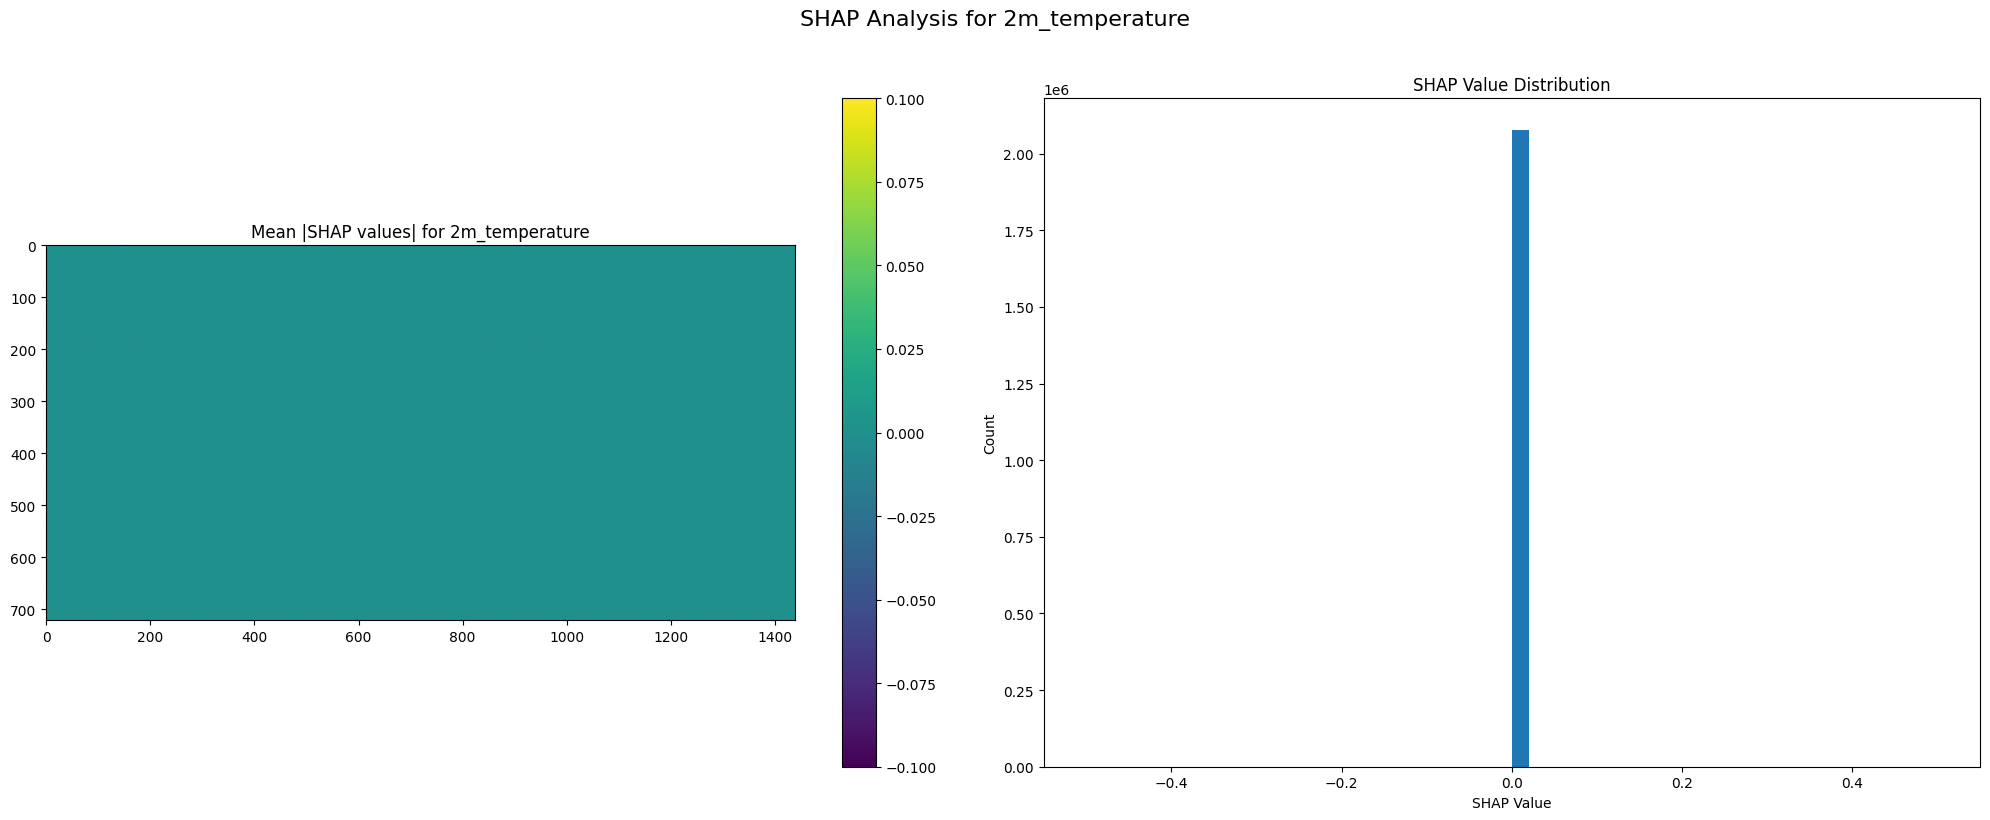

 20%|██        | 1/5 [00:37<02:29, 37.47s/it]


Analyzing variable: specific_humidity
Creating explainer for specific_humidity...
Computing SHAP values for specific_humidity...


  0%|          | 0/1 [00:00<?, ?it/s]

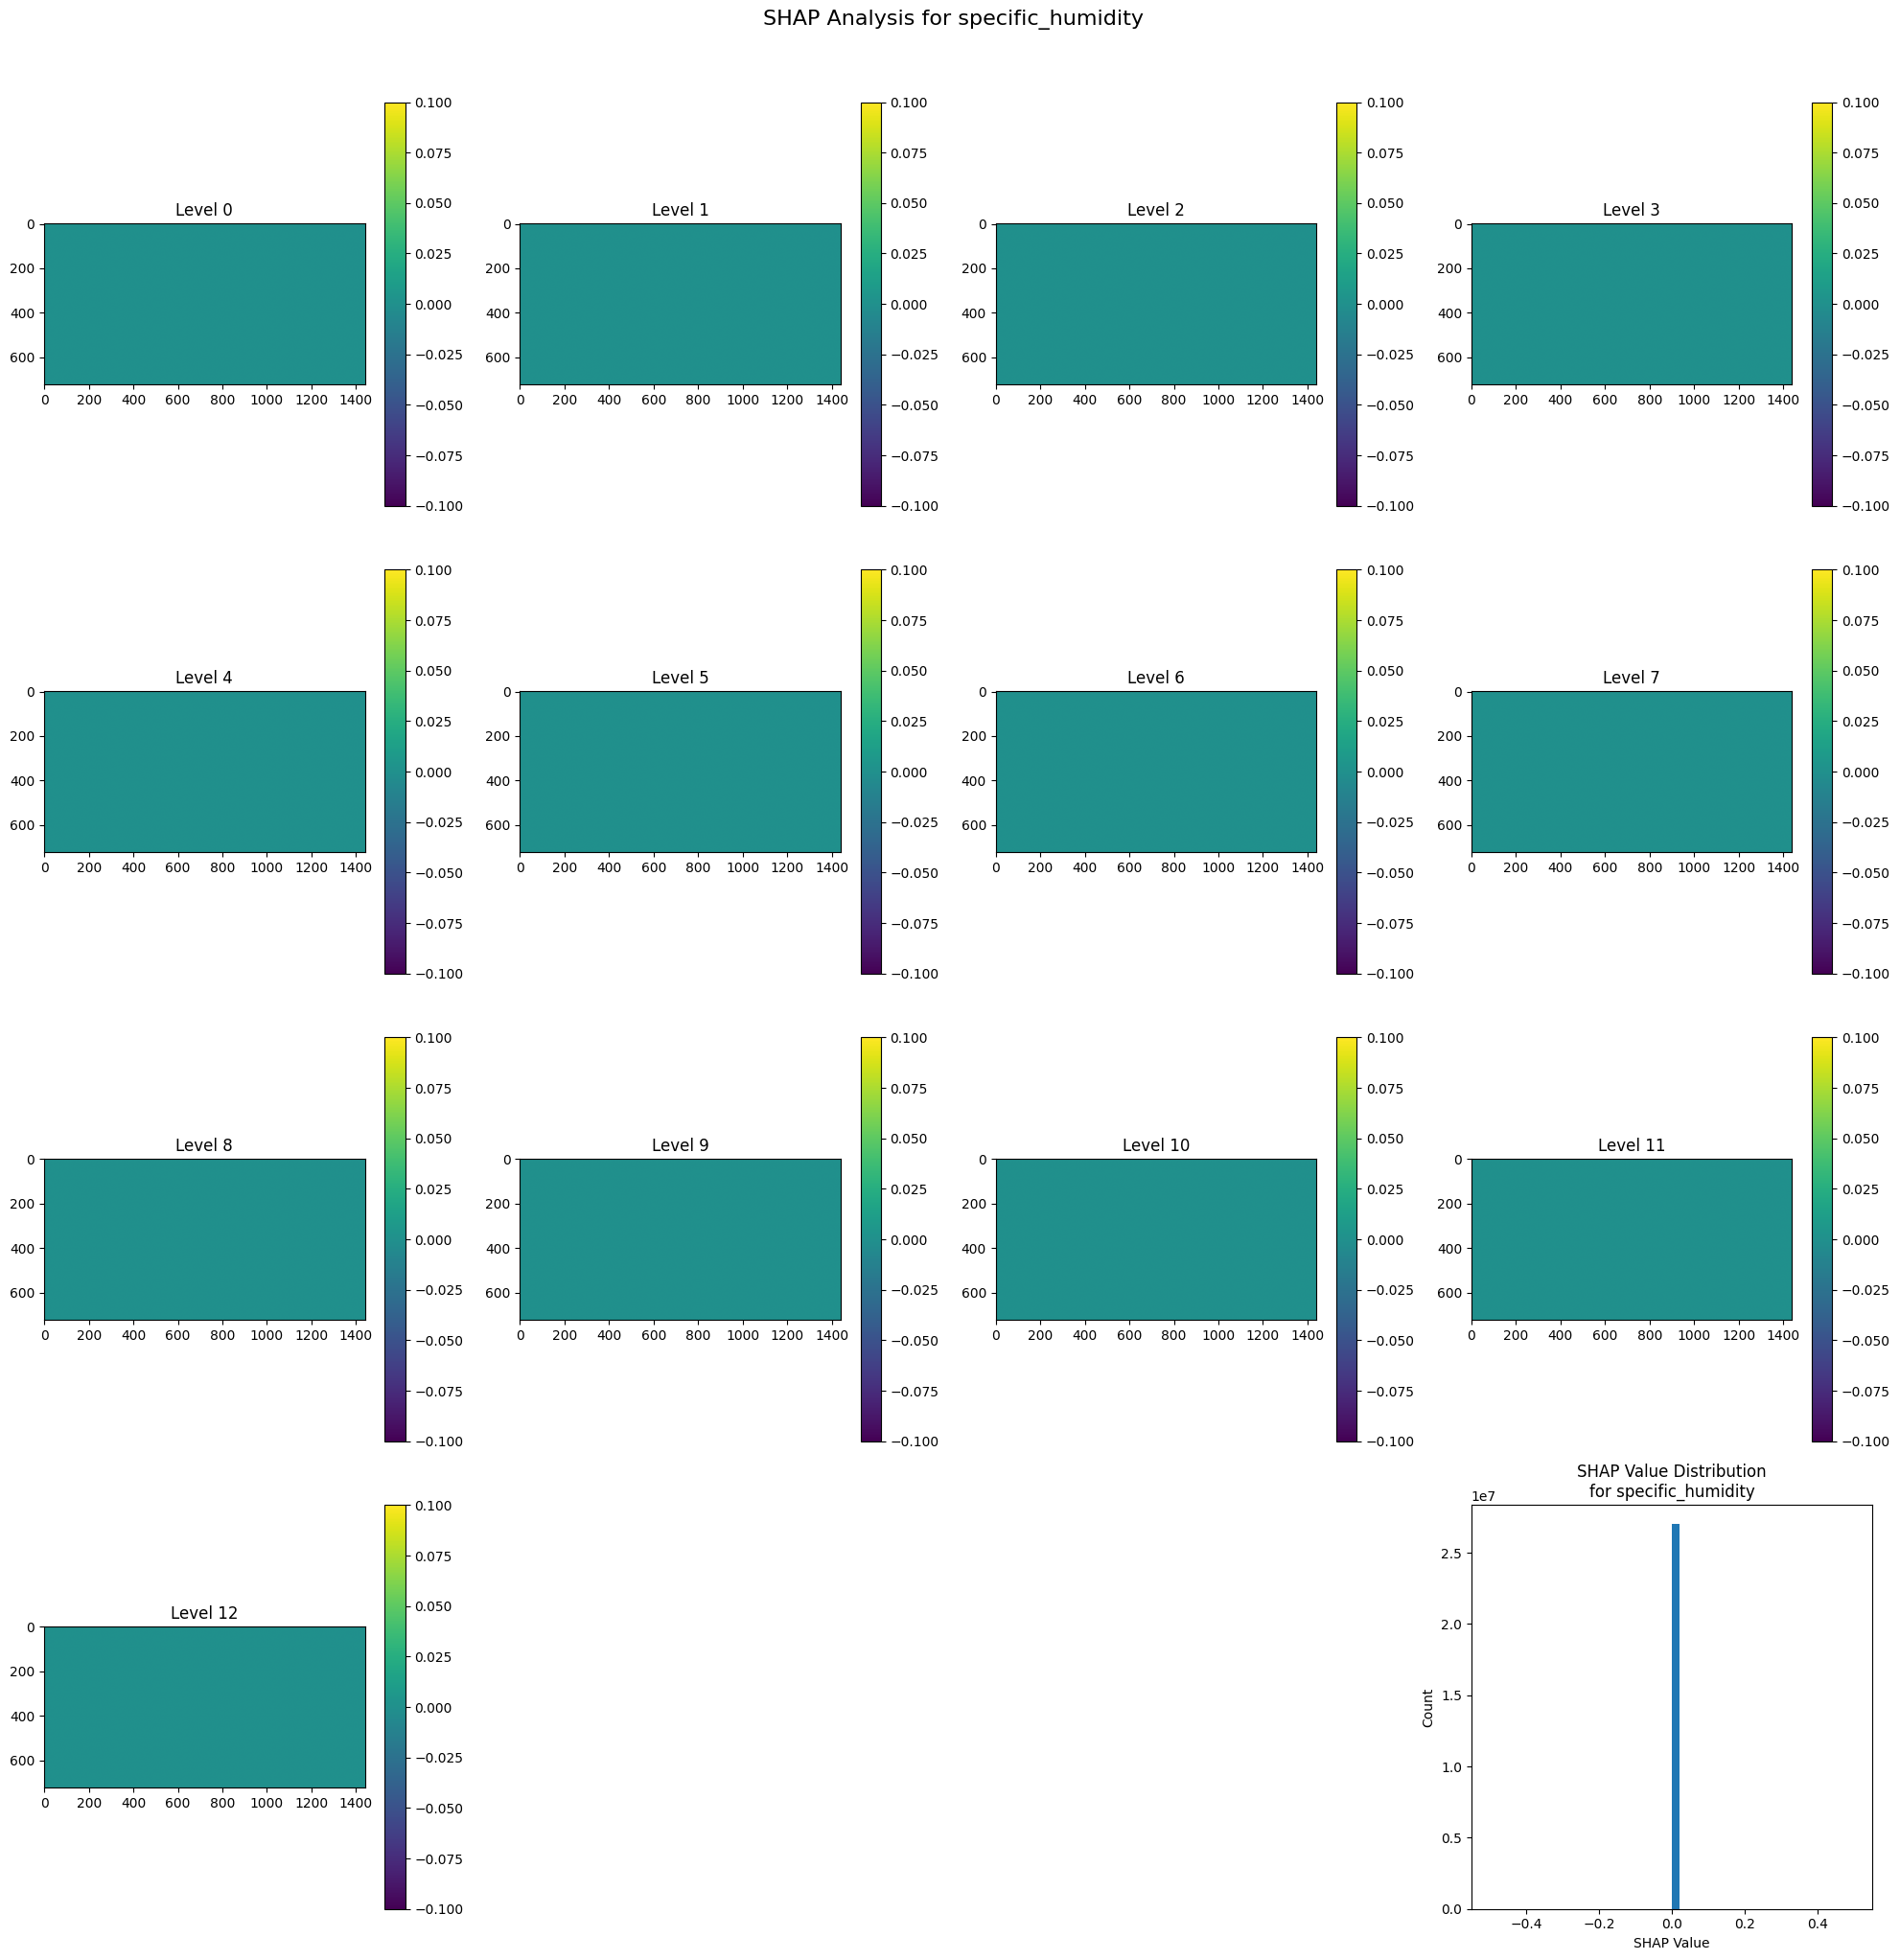

 40%|████      | 2/5 [05:07<08:42, 174.16s/it]


Analyzing variable: geopotential
Creating explainer for geopotential...
Computing SHAP values for geopotential...


  0%|          | 0/1 [00:00<?, ?it/s]

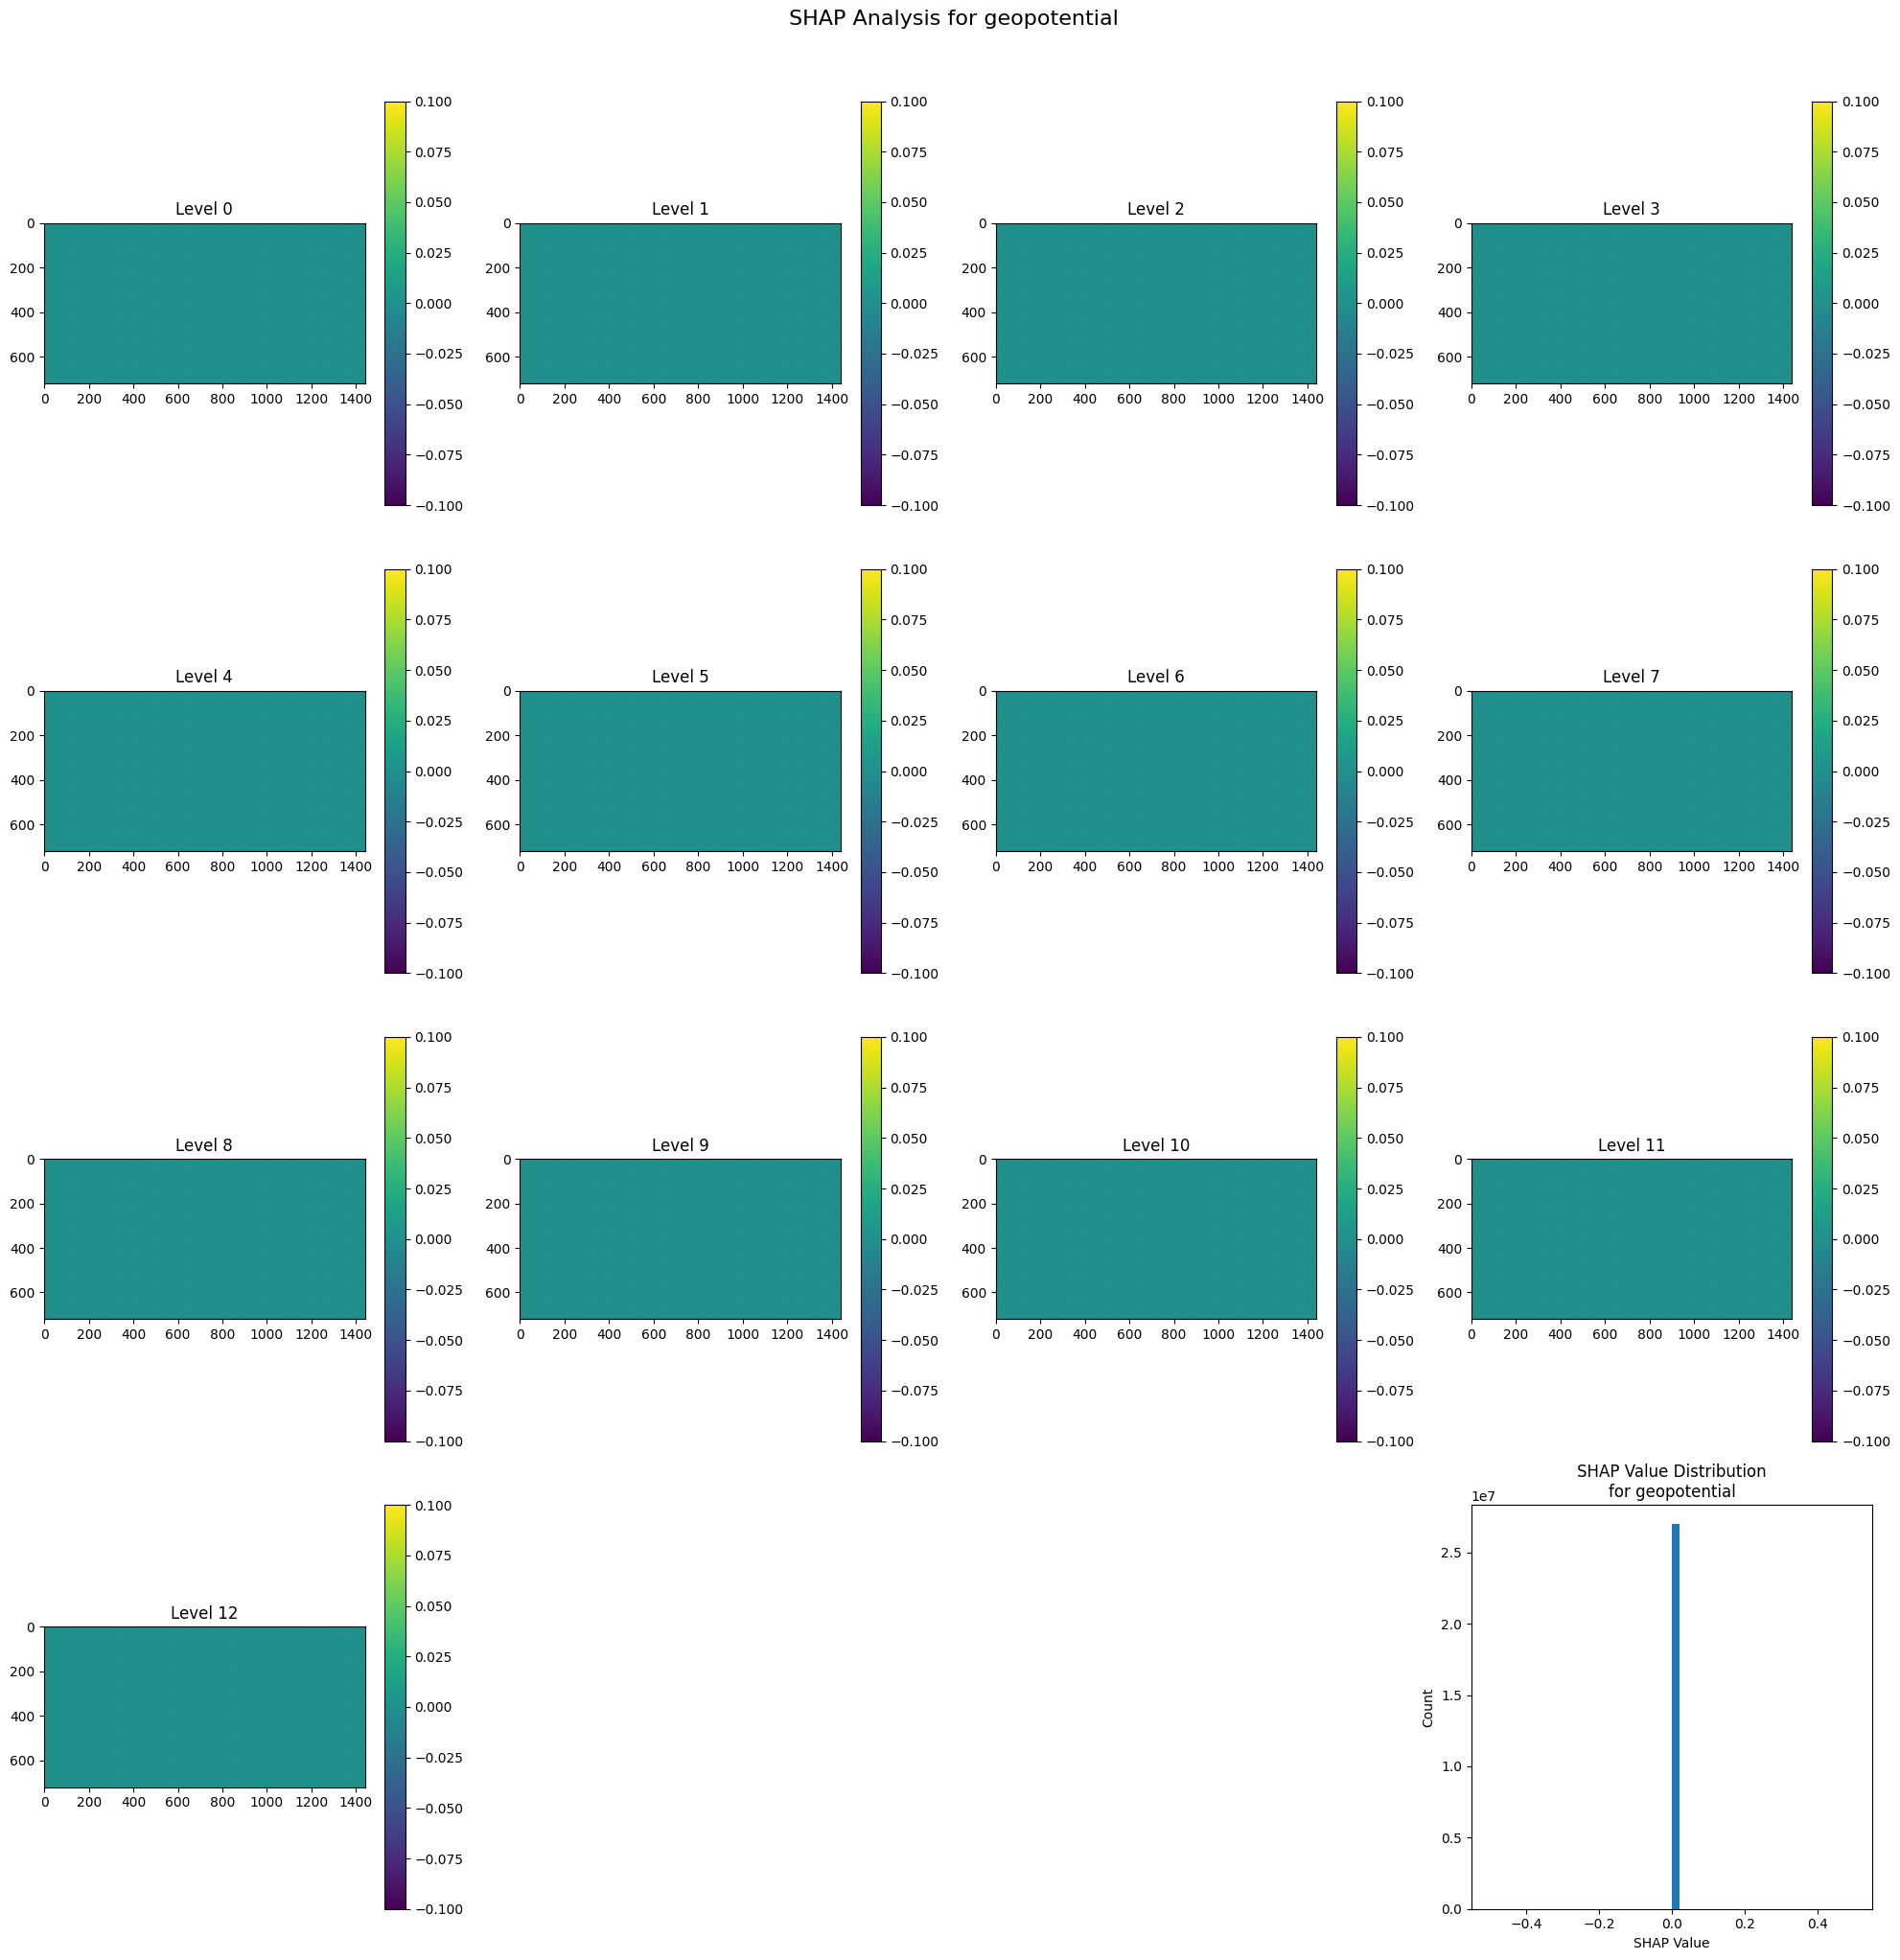

 60%|██████    | 3/5 [09:39<07:18, 219.00s/it]


Analyzing variable: u_component_of_wind
Creating explainer for u_component_of_wind...
Computing SHAP values for u_component_of_wind...


  0%|          | 0/1 [00:00<?, ?it/s]

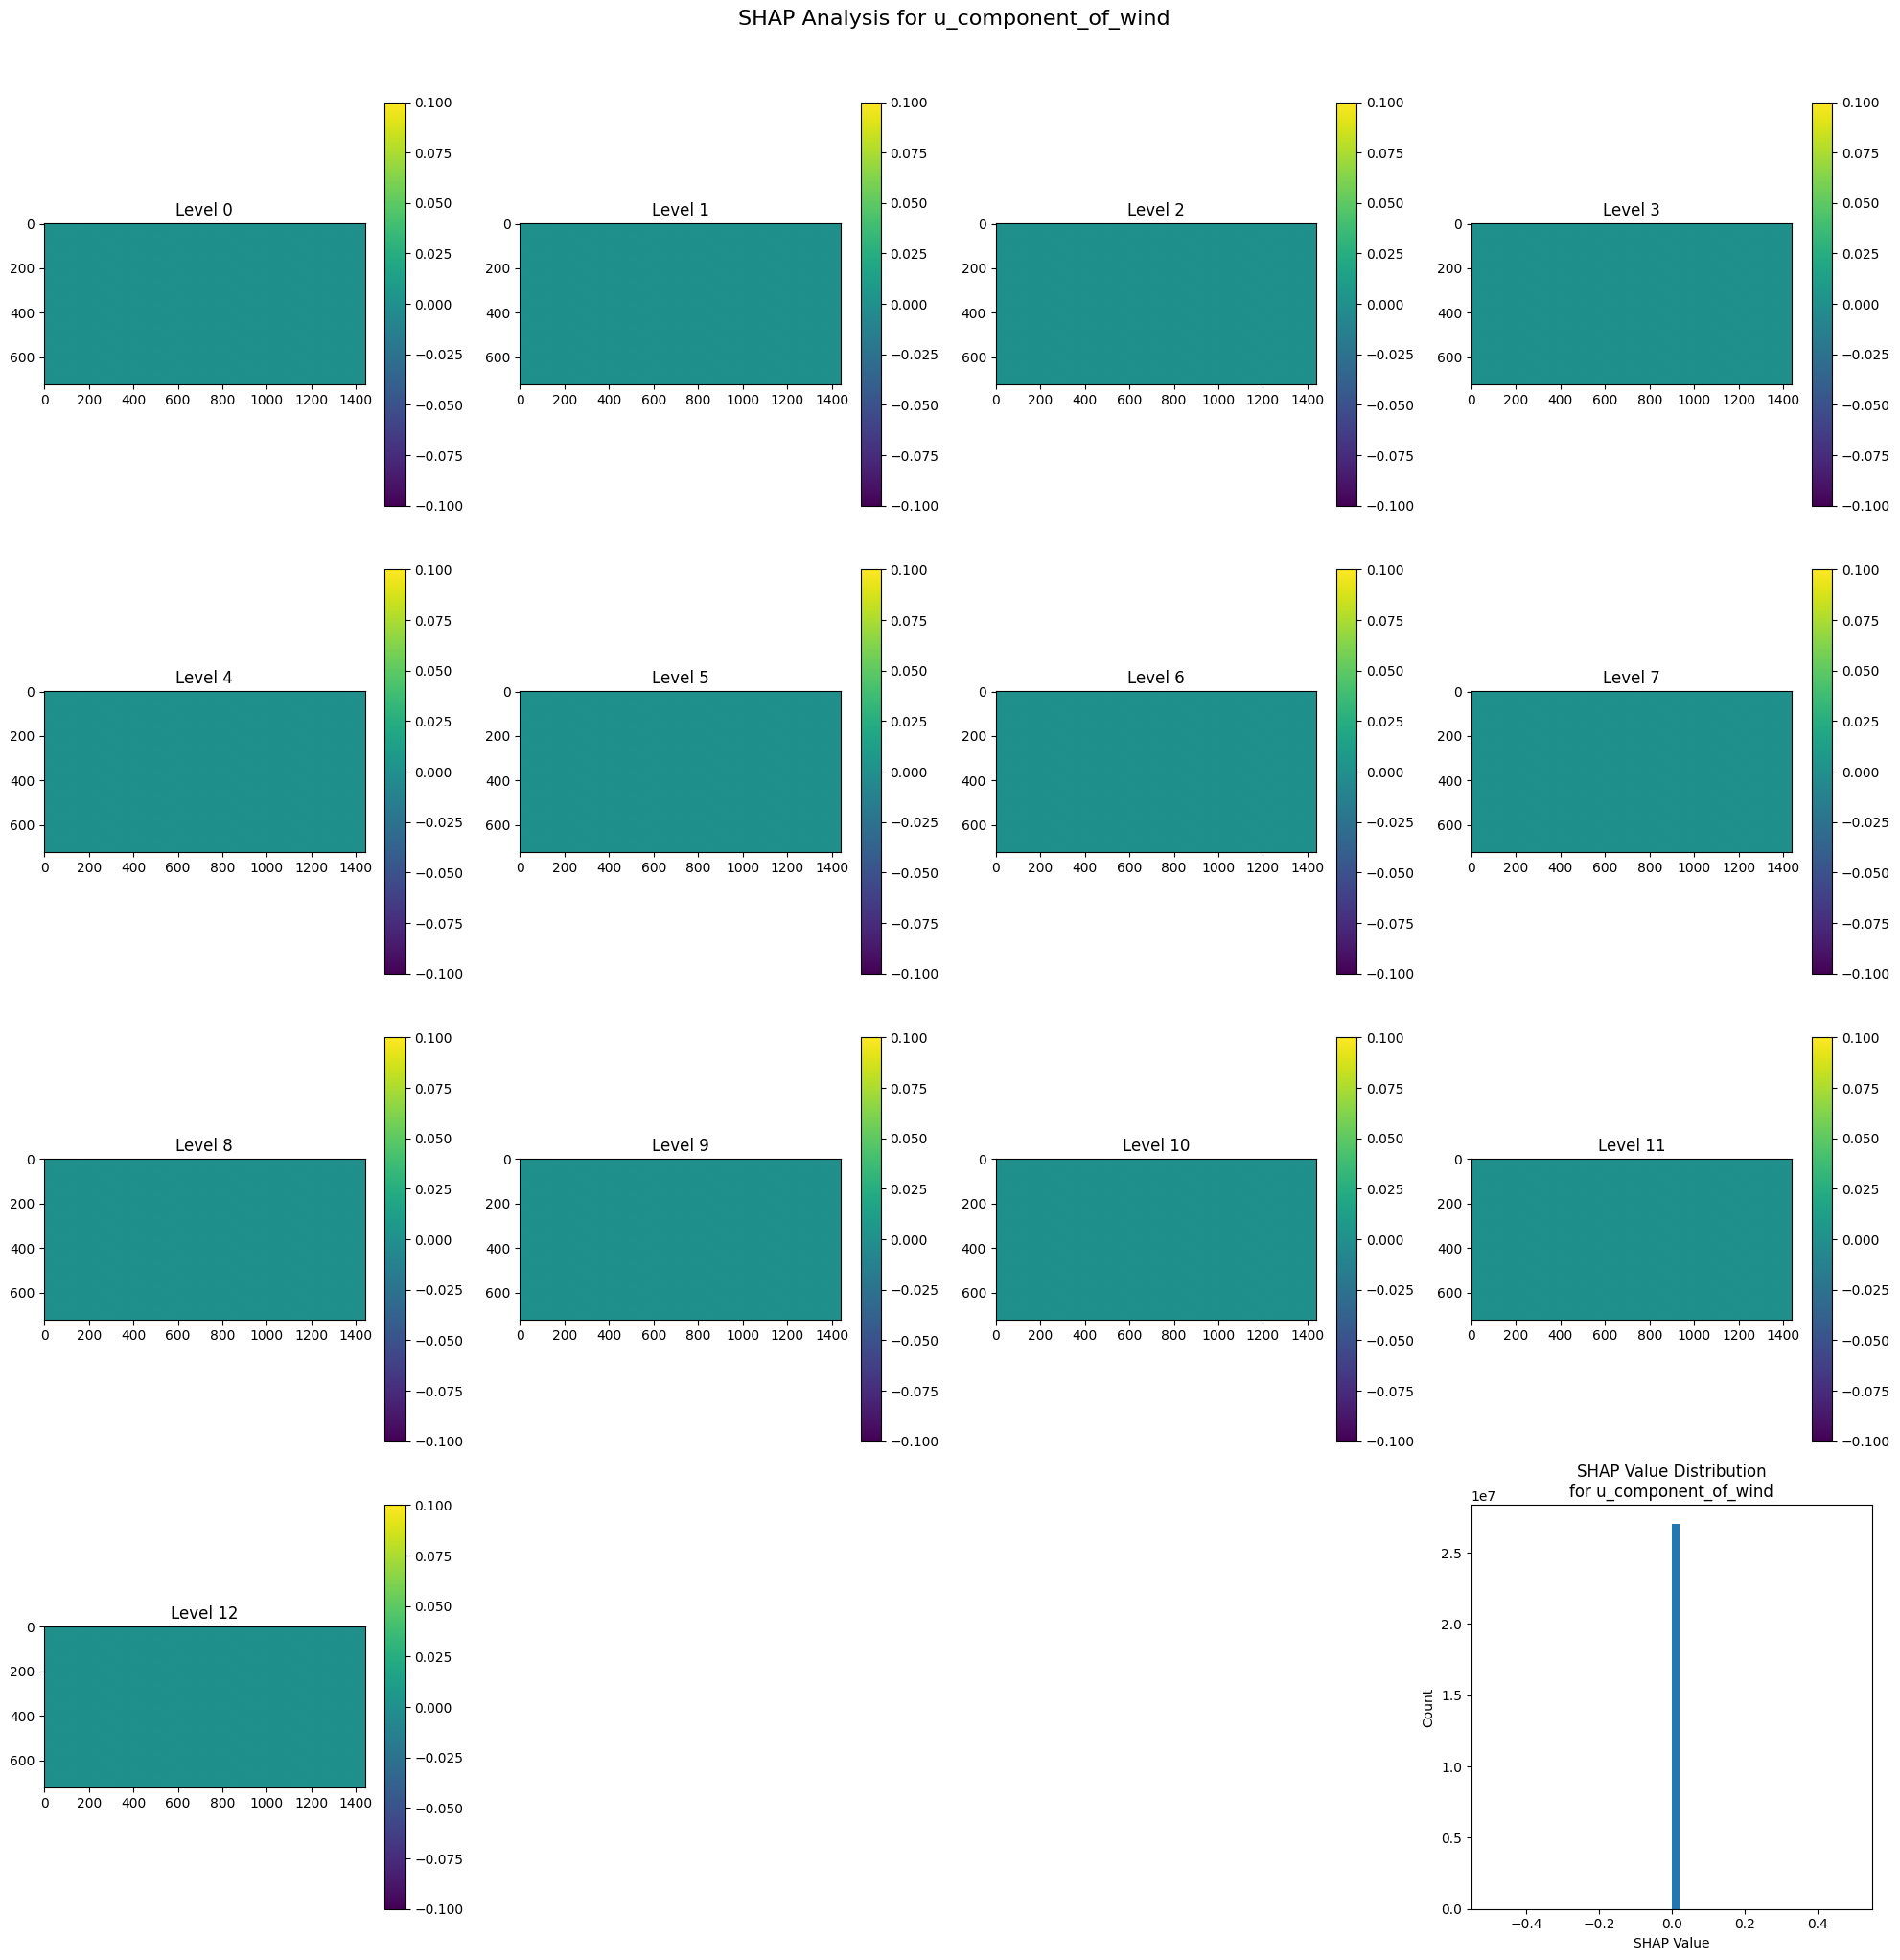

 80%|████████  | 4/5 [14:13<04:00, 240.48s/it]


Analyzing variable: v_component_of_wind
Creating explainer for v_component_of_wind...
Computing SHAP values for v_component_of_wind...


  0%|          | 0/1 [00:00<?, ?it/s]

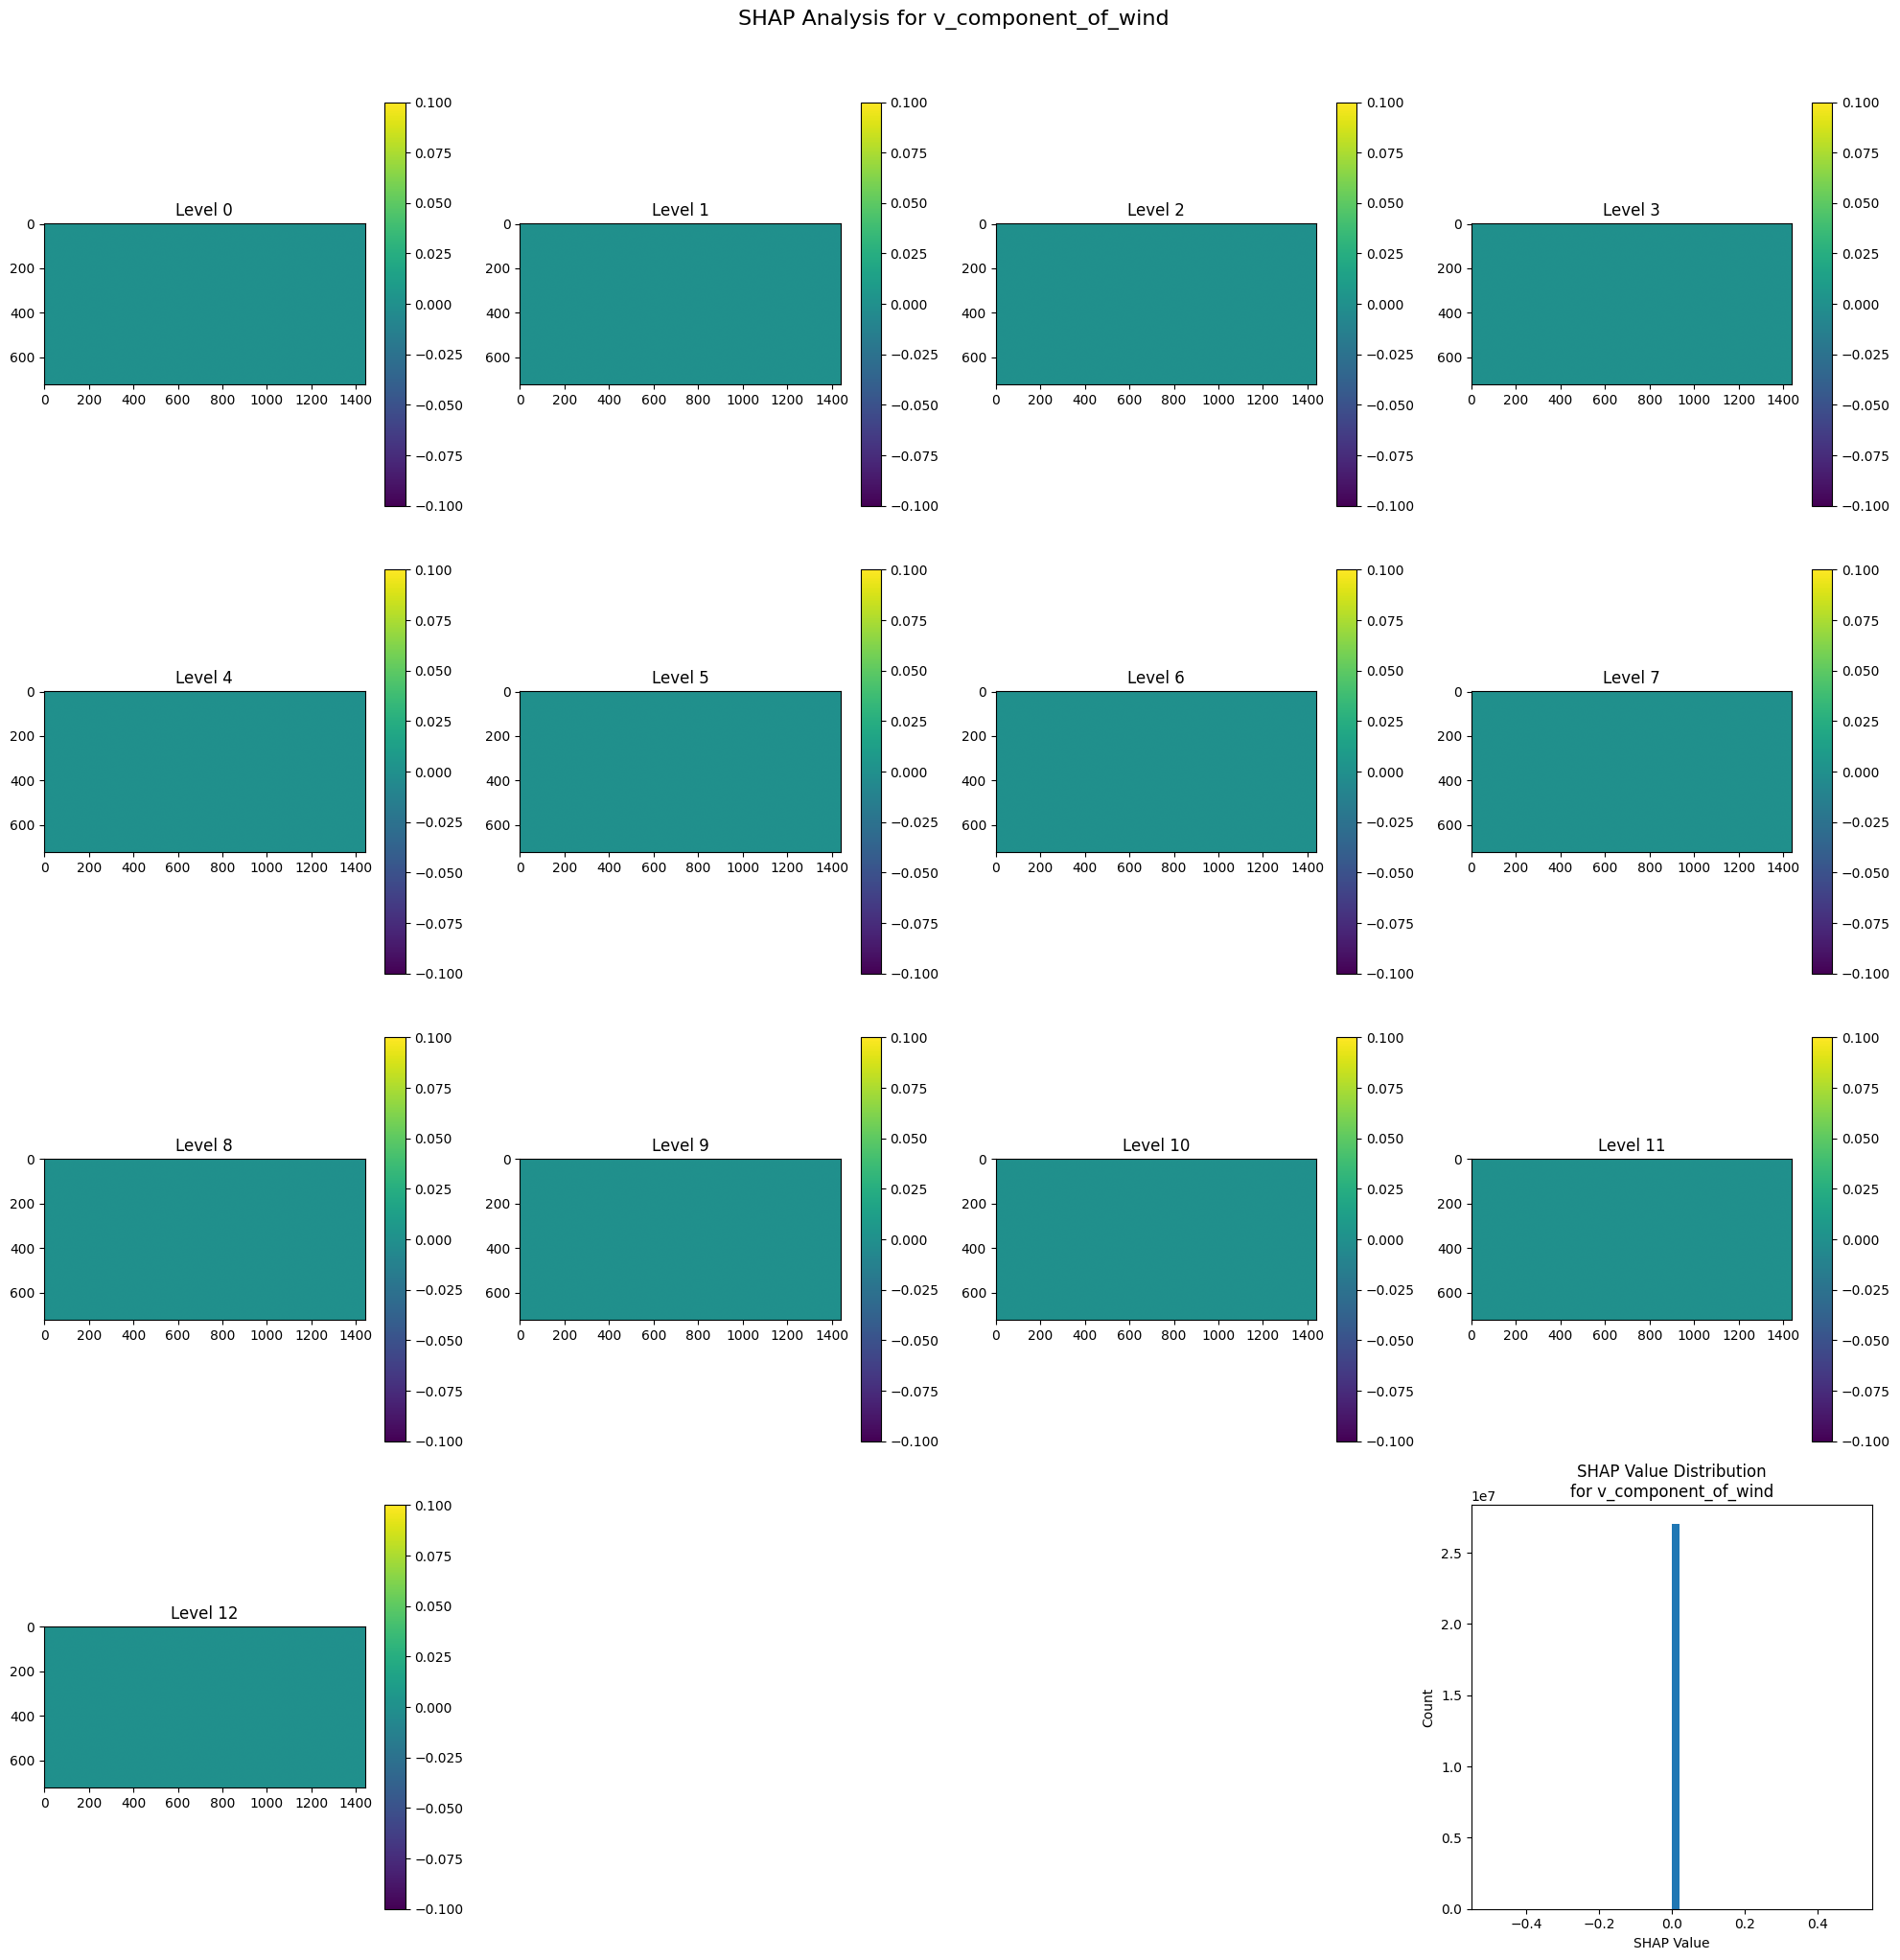

100%|██████████| 5/5 [18:45<00:00, 225.12s/it]


In [27]:
%pip install numpy==2.0.0

import shap
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

def analyze_graphcast_with_shap(train_inputs, train_targets, train_forcings, run_forward_jitted, 
                              variables_to_analyze=None, n_samples=10, n_background_samples=5):
    """
    Analyze GraphCast predictions using SHAP values for multiple variables.
    """
    if variables_to_analyze is None:
        variables_to_analyze = list(train_inputs.data_vars.keys())
    
    print(f"Analyzing {len(variables_to_analyze)} variables: {variables_to_analyze}")
    
    shap_results = {}
    
    for variable in tqdm(variables_to_analyze):
        print(f"\nAnalyzing variable: {variable}")
        
        # Prepare data for the current variable
        def prepare_variable_data(dataset, var_name):
            if var_name in dataset:
                data = dataset[var_name].values
                original_shape = data.shape
                return data.reshape(data.shape[0], -1), original_shape
            return None, None
        
        input_data, original_shape = prepare_variable_data(train_inputs, variable)
        if input_data is None:
            print(f"Variable {variable} not found in input data")
            continue
            
        # Modified model prediction function that returns only the target variable
        def model_predict_var(x):
            try:
                # Reshape input back to original dimensions
                shaped_x = x.reshape((1,) + original_shape[1:])
                
                # Create input dataset
                input_data = train_inputs.copy()
                input_data[variable].values = shaped_x
                
                # Run prediction
                predictions = run_forward_jitted(
                    rng=jax.random.PRNGKey(0),
                    inputs=input_data,
                    targets_template=train_targets * np.nan,
                    forcings=train_forcings)
                
                # Return only the predictions for the current variable
                return predictions[variable].values.reshape(-1)
            except Exception as e:
                print(f"Prediction error for {variable}: {e}")
                return None
        
        try:
            # Create background dataset
            background_indices = np.random.choice(
                input_data.shape[0], 
                size=min(n_background_samples, input_data.shape[0]), 
                replace=False
            )
            background_data = input_data[background_indices]
            
            print(f"Creating explainer for {variable}...")
            explainer = shap.KernelExplainer(model_predict_var, background_data)
            
            print(f"Computing SHAP values for {variable}...")
            shap_values = explainer.shap_values(
                input_data[:1],  # Explain first timestep
                nsamples=n_samples
            )
            
            # Store results
            shap_results[variable] = {
                'values': shap_values,
                'original_shape': original_shape
            }
            
            # Create visualizations
            plot_shap_results(variable, shap_values, original_shape, train_inputs[variable])
            
        except Exception as e:
            print(f"SHAP analysis error for {variable}: {e}")
            import traceback
            traceback.print_exc()
    
    return shap_results

def plot_shap_results(variable, shap_values, original_shape, input_data):
    """
    Create visualizations for SHAP results with support for 3D data.
    """
    # Handle both array and list types of shap_values
    if isinstance(shap_values, list):
        shap_values = np.array(shap_values)
    
    # Reshape SHAP values back to spatial dimensions
    reshaped_values = shap_values.reshape((-1,) + original_shape[1:])
    
    # Determine if we're dealing with pressure level data
    has_pressure_levels = len(original_shape) > 3 and original_shape[-3] == 13
    
    if has_pressure_levels:
        # Create subplots for each pressure level, using a 4x4 grid (16 total spaces)
        n_levels = original_shape[-3]  # 13 levels
        n_cols = 4
        n_rows = 4  # Fixed to 4 rows to accommodate 13 levels plus distribution plot
        fig = plt.figure(figsize=(20, 20))
        
        # Plot each pressure level
        for level in range(n_levels):
            ax = plt.subplot(n_rows, n_cols, level + 1)
            level_data = reshaped_values[0, 0, level]  # Select specific pressure level
            im = ax.imshow(level_data)
            ax.set_title(f'Level {level}')
            plt.colorbar(im, ax=ax)
        
        # Add distribution plot in the last spot
        ax = plt.subplot(n_rows, n_cols, 16)  # Use last position in 4x4 grid
        valid_shap = reshaped_values[~np.isnan(reshaped_values)]
        if len(valid_shap) > 0:
            ax.hist(valid_shap, bins=50)
            ax.set_title(f'SHAP Value Distribution\nfor {variable}')
            ax.set_xlabel('SHAP Value')
            ax.set_ylabel('Count')
    else:
        # For 2D variables (like 2m_temperature)
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot mean absolute SHAP values
        mean_abs_shap = np.mean(np.abs(reshaped_values), axis=0)
        if len(mean_abs_shap.shape) > 2:
            mean_abs_shap = mean_abs_shap.mean(axis=0)
        im1 = axes[0].imshow(mean_abs_shap)
        axes[0].set_title(f'Mean |SHAP values| for {variable}')
        plt.colorbar(im1, ax=axes[0])
        
        # Plot SHAP value distribution
        shap_flat = reshaped_values.flatten()
        valid_shap = shap_flat[~np.isnan(shap_flat)]
        if len(valid_shap) > 0:
            axes[1].hist(valid_shap, bins=50)
            axes[1].set_title(f'SHAP Value Distribution')
            axes[1].set_xlabel('SHAP Value')
            axes[1].set_ylabel('Count')
    
    plt.suptitle(f'SHAP Analysis for {variable}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Example usage
variables_to_analyze = [
    '2m_temperature', 
    'specific_humidity', 
    'geopotential',
    'u_component_of_wind',
    'v_component_of_wind'
]

# Print input shapes for debugging
print("\nInput dataset shapes:")
for var in variables_to_analyze:
    if var in train_inputs:
        print(f"{var}: {train_inputs[var].shape}")

try:
    shap_results = analyze_graphcast_with_shap(
        train_inputs=train_inputs,
        train_targets=train_targets,
        train_forcings=train_forcings,
        run_forward_jitted=run_forward_jitted,
        variables_to_analyze=variables_to_analyze,
        n_samples=5,  # Reduced for testing
        n_background_samples=3  # Reduced for testing
    )
except Exception as e:
    print(f"Analysis failed with error: {e}")
    import traceback
    traceback.print_exc()